# PCNA experiments raw data viewer

This notebook takes the output of the 4-channel brightfield, gfp-h2b, rfp-h2b, irfp-pcna experiments, formats the images into stacks and displays the stacks in Napari.

In [2]:
import napari
print("Napari version no.:", napari.__version__)
import btrack
print('Btrack version', btrack.__version__)
import os, glob, enum
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from skimage.io import imread
from natsort import natsorted
from datetime import datetime
from btrack.utils import tracks_to_napari

Napari version no.: 0.4.11
Btrack version 0.4.2


### Set data folder and number of channels to display

In [20]:
### set root data folder
root_folder = '/home/nathan/data/kraken/commitment/'
expt_IDs = natsorted([ID for ID in os.listdir(root_folder) if 'MK' in ID])
print('Experiment/position list:', [(expt,natsorted([pos for pos in os.listdir(os.path.join(root_folder, expt)) if 'Pos' in pos])) for expt in expt_IDs])
### not entirely sure this is the correct use of a class but im still learning
@enum.unique
class channels(enum.Enum):
    bf = 0 
    gfp = 1
    rfp = 2
    irfp = 3
    cp_masks = 4

Experiment/position list: [('MK0000', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'Pos17', 'Pos18', 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']), ('MK0001', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15']), ('MK0002', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15']), ('MK0003', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15'])]


Select one position if necessary

In [23]:
expt = 'MK0000'
pos = 'Pos5'#'Pos15'

data_folder = os.path.join(root_folder, '{}/{}'.format(expt, pos)) #'/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15'#'/media/nathan/Transcend/Nathan/data/pcna/test_210422/Pos7'
#data_folder = os.path.join(root_folder, '{}'.format(pos)) #'/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15'#'/media/nathan/Transcend/Nathan/data/pcna/test_210422/Pos7'

### Compile folders of single frame images into stacks if necessary

In [19]:
## move raw files into own folder inside 
if '{}_raw'.format(pos) not in os.listdir(data_folder):
    os.mkdir(os.path.join(data_folder,'{}_raw'.format(pos)))
    print(output_dir, 'directory created')
    files = glob.glob(os.path.join(data_folder, 'img_channel00*.tif'))
    for file in tqdm(files):
        os.rename(file, file.replace('img', f'{pos}_raw/img'))

In [6]:
## compile stacks
output_dir = os.path.join(data_folder,'{}_stacks'.format(pos))
if '{}_stacks'.format(pos) not in os.listdir(data_folder):
    os.mkdir(os.path.join(data_folder,'{}_stacks'.format(pos)))
    print(output_dir, 'directory created')
    for channel in channels:
        print(channel.name, 'compiling')
        files = glob.glob(os.path.join(data_folder, 
                                       '{}_raw'.format(pos),
                                       'img_channel00{}*.tif'.format(channel.value)))
        stack = []
        for file in tqdm(natsorted(files)):
            tif = np.array(tiff.imread(file),dtype=np.uint8)
            tif_w,tif_h = np.shape(tif)[0],np.shape(tif)[1]
            tif = tif[int((tif_w-1200)/2):int(tif_w-(tif_w-1200)/2),int((tif_h-1600)/2):int(tif_h-(tif_h-1600)/2)] ## cropping
            stack.append(tif)
        stack = np.stack(stack,axis=0)
        with tiff.TiffWriter(os.path.join(output_dir,'{}.tif'.format(channel.name)),imagej=True) as output_file:
            output_file.save(stack)
        print(channel.name, 'saved out')
else:
    print('looks like stacks already exist bro')

/home/nathan/data/kraken/pcna/MK0002/Pos5/Pos5_stacks directory created
bf compiling


100%|██████████| 1200/1200 [00:16<00:00, 71.09it/s]


bf saved out
gfp compiling


100%|██████████| 1200/1200 [00:55<00:00, 21.47it/s]


gfp saved out
rfp compiling


100%|██████████| 1200/1200 [00:58<00:00, 20.65it/s]


rfp saved out
irfp compiling


100%|██████████| 1200/1200 [00:51<00:00, 23.12it/s]


irfp saved out


In [63]:
## compile mask stacks
output_dir = os.path.join(data_folder,'{}_stacks'.format(pos))
for channel in channels:
        print(channel.name, 'compiling')
        files = glob.glob(os.path.join(data_folder, 
                                       '{}_cp_masks'.format(pos),
                                       'img_channel00{}*.png'.format(channel.value)))
        stack = []
        for file in tqdm(natsorted(files)):
            tif = np.array(tiff.imread(file),dtype=np.uint8)
            tif_w,tif_h = np.shape(tif)[0],np.shape(tif)[1]
            tif = tif[int((tif_w-1200)/2):int(tif_w-(tif_w-1200)/2),int((tif_h-1600)/2):int(tif_h-(tif_h-1600)/2)] ## cropping
            stack.append(tif)
        stack = np.stack(stack,axis=0)
        with tiff.TiffWriter(os.path.join(output_dir,'{}_cp_masks.tif'.format(channel.name)),imagej=True) as output_file:
            output_file.save(stack)
        print(channel.name, 'saved out')

bf compiling


0it [00:00, ?it/s]


ValueError: need at least one array to stack

#### Compile multiple experiments and positions from single frame images into stacks

In [32]:
glob.glob(os.path.join(data_folder, 
                               f'{pos}_cp_masks',
                               f'img_channel00*.png'))

['/home/nathan/data/kraken/commitment/MK0001/Pos0/Pos0_cp_masks/img_channel001_position000_time000000028_z000_cp_masks.png',
 '/home/nathan/data/kraken/commitment/MK0001/Pos0/Pos0_cp_masks/img_channel001_position000_time000000602_z000_cp_masks.png',
 '/home/nathan/data/kraken/commitment/MK0001/Pos0/Pos0_cp_masks/img_channel001_position000_time000000693_z000_cp_masks.png',
 '/home/nathan/data/kraken/commitment/MK0001/Pos0/Pos0_cp_masks/img_channel001_position000_time000000092_z000_cp_masks.png',
 '/home/nathan/data/kraken/commitment/MK0001/Pos0/Pos0_cp_masks/img_channel001_position000_time000000097_z000_cp_masks.png',
 '/home/nathan/data/kraken/commitment/MK0001/Pos0/Pos0_cp_masks/img_channel001_position000_time000000818_z000_cp_masks.png',
 '/home/nathan/data/kraken/commitment/MK0001/Pos0/Pos0_cp_masks/img_channel001_position000_time000000443_z000_cp_masks.png',
 '/home/nathan/data/kraken/commitment/MK0001/Pos0/Pos0_cp_masks/img_channel001_position000_time000000404_z000_cp_masks.png',


In [34]:
if channel.name == 'cp_masks':
    files = glob.glob(os.path.join(data_folder, 
                               f'{pos}_cp_masks',
                               f'img_channel00*.png'))
else:
    files = glob.glob(os.path.join(data_folder, 
                               f'{pos}_raw',
                               f'img_channel00{channel.value}*.tif'))
stack = []
for file in tqdm(natsorted(files)):
    tif = np.array(imread(file),dtype=np.uint8)
    ### unnecessary bc images are not aligned
    #tif_w,tif_h = np.shape(tif)[0],np.shape(tif)[1]
    #tif = tif[int((tif_w-1200)/2):int(tif_w-(tif_w-1200)/2),int((tif_h-1600)/2):int(tif_h-(tif_h-1600)/2)] ## cropping
    stack.append(tif)
stack = np.stack(stack,axis=0)
with tiff.TiffWriter(os.path.join(data_folder,f'{pos}_stacks',f'{channel.name}.tif'),imagej=True) as output_file:
    output_file.save(stack)
print(channel.name, 'saved out')

100%|██████████| 912/912 [00:29<00:00, 31.36it/s]


cp_masks saved out


In [ ]:
for expt in tqdm(expt_IDs):
    ### get all positions in that experiment
    pos_list = natsorted([pos for pos in os.listdir(os.path.join(root_folder, expt)) if 'Pos' in pos])
    for pos in tqdm(pos_list):
        print('Starting', expt, pos)
        data_folder = os.path.join(root_folder, f'{expt}/{pos}')
        ### check if stacks already made
        if f'{pos}_stacks' not in os.listdir(data_folder):
            ### make output dir for stacks and input dir for raw files and cp mask directory
            os.mkdir(os.path.join(data_folder,f'{pos}_stacks'))
            os.mkdir(os.path.join(data_folder,f'{pos}_raw'))
            os.mkdir(os.path.join(data_folder, f'{pos}_cp_masks'))
            print('Output, input and cellpose mask directories created')
            ### move raw images into directory
            files = glob.glob(os.path.join(data_folder, 'img_channel00*'))
            for file in files:
                ### if cp_mask then move into cp_mask dir
                if 'cp_mask' in file:
                    os.rename(file, file.replace('img', f'{pos}_cp_masks/img'))
                ### if standard file then move there
                else:
                    os.rename(file, file.replace('img', f'{pos}_raw/img'))
            print(expt, pos, 'files moved into separate directories')
            for channel in channels:
                print(channel.name, 'compiling')
                if channel.name == 'cp_masks':
                    files = glob.glob(os.path.join(data_folder, 
                               f'{pos}_cp_masks',
                               f'img_channel00*.png'))
                else:
                    files = glob.glob(os.path.join(data_folder, 
                                               f'{pos}_raw',
                                               f'img_channel00{channel.value}*.tif'))
                stack = []
                if files == []:
                    continue
                for file in natsorted(files):
                    if channel.name == 'cp_masks':
                        tif = np.array(imread(file), dtype=np.uint8)
                    else:
                        tif = np.array(tiff.imread(file),dtype=np.uint8)
                    ### unnecessary bc images are not aligned
                    #tif_w,tif_h = np.shape(tif)[0],np.shape(tif)[1]
                    #tif = tif[int((tif_w-1200)/2):int(tif_w-(tif_w-1200)/2),int((tif_h-1600)/2):int(tif_h-(tif_h-1600)/2)] ## cropping
                    stack.append(tif)
                stack = np.stack(stack,axis=0)
                with tiff.TiffWriter(os.path.join(data_folder,f'{pos}_stacks',f'{channel.name}.tif'),imagej=True) as output_file:
                    output_file.save(stack)
                print(channel.name, 'saved out')
        else:
            print('looks like stacks already exist bro')
        
     

100%|██████████| 24/24 [00:00<00:00, 1836.35it/s]


Starting MK0000 Pos0
looks like stacks already exist bro
Starting MK0000 Pos1
looks like stacks already exist bro
Starting MK0000 Pos2
looks like stacks already exist bro
Starting MK0000 Pos3
looks like stacks already exist bro
Starting MK0000 Pos4
looks like stacks already exist bro
Starting MK0000 Pos5
looks like stacks already exist bro
Starting MK0000 Pos6
looks like stacks already exist bro
Starting MK0000 Pos7
looks like stacks already exist bro
Starting MK0000 Pos8
looks like stacks already exist bro
Starting MK0000 Pos9
looks like stacks already exist bro
Starting MK0000 Pos10
looks like stacks already exist bro
Starting MK0000 Pos11
looks like stacks already exist bro
Starting MK0000 Pos12
looks like stacks already exist bro
Starting MK0000 Pos13
looks like stacks already exist bro
Starting MK0000 Pos14
looks like stacks already exist bro
Starting MK0000 Pos15
looks like stacks already exist bro
Starting MK0000 Pos16
looks like stacks already exist bro
Starting MK0000 Pos17
lo


  0%|          | 0/16 [00:00<?, ?it/s]

Starting MK0001 Pos0
looks like stacks already exist bro
Starting MK0001 Pos1
Output, input and cellpose mask directories created
MK0001 Pos1 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 12%|█▎        | 2/16 [03:20<23:23, 100.24s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos2
Output, input and cellpose mask directories created
MK0001 Pos2 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 19%|█▉        | 3/16 [07:39<36:01, 166.29s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos3
Output, input and cellpose mask directories created
MK0001 Pos3 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 25%|██▌       | 4/16 [12:02<40:29, 202.48s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos4
Output, input and cellpose mask directories created
MK0001 Pos4 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 31%|███▏      | 5/16 [16:23<40:49, 222.69s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos5
Output, input and cellpose mask directories created
MK0001 Pos5 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 38%|███▊      | 6/16 [21:58<43:19, 259.95s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos6
Output, input and cellpose mask directories created
MK0001 Pos6 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 44%|████▍     | 7/16 [26:42<40:11, 267.95s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos7
Output, input and cellpose mask directories created
MK0001 Pos7 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 50%|█████     | 8/16 [31:36<36:48, 276.03s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos8
Output, input and cellpose mask directories created
MK0001 Pos8 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 56%|█████▋    | 9/16 [36:08<32:02, 274.67s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos9
Output, input and cellpose mask directories created
MK0001 Pos9 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 62%|██████▎   | 10/16 [40:23<26:53, 268.86s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos10
Output, input and cellpose mask directories created
MK0001 Pos10 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 69%|██████▉   | 11/16 [44:41<22:07, 265.54s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos11
Output, input and cellpose mask directories created
MK0001 Pos11 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 75%|███████▌  | 12/16 [49:31<18:11, 272.98s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos12
Output, input and cellpose mask directories created
MK0001 Pos12 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 81%|████████▏ | 13/16 [53:47<13:22, 267.62s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos13
Output, input and cellpose mask directories created
MK0001 Pos13 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 88%|████████▊ | 14/16 [58:15<08:55, 267.86s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos14
Output, input and cellpose mask directories created
MK0001 Pos14 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling
rfp saved out
irfp compiling



 94%|█████████▍| 15/16 [1:02:35<04:25, 265.45s/it]

irfp saved out
cp_masks compiling
Starting MK0001 Pos15
Output, input and cellpose mask directories created
MK0001 Pos15 files moved into separate directories
bf compiling
bf saved out
gfp compiling
gfp saved out
rfp compiling


### Load images 

In [25]:
data_folder

'/home/nathan/data/kraken/pcna/MK0000/Pos5'

from confocal data sets

In [22]:
### load images confocal
output_dir = os.path.join(data_folder,'{}_stacks'.format(pos))
stack_fn = {}
for channel in channels:
    stack_fn[channel.name] = glob.glob(os.path.join(output_dir, 'Chan{}*.tif'.format(channel.value)))
    #stack_fn[channel.name] = glob.glob(os.path.join(output_dir, '{}.tif'.format(channel.name)))
gfp = imread(stack_fn['gfp'][0])
print('gfp loaded')
bf = imread(stack_fn['bf'][0])
print('bf loaded')
rfp = imread(stack_fn['rfp'][0])
print('rfp loaded')
irfp = imread(stack_fn['irfp'][0])
print('irfp loaded')videoconferencing system only works with Teams.
#masks = imread(stack_fn['cp_masks'][0])

IndexError: list index out of range

In [57]:
masks = imread(stack_fn['cp_masks'][0])

In [58]:
masks.shape

(150, 512, 512)

In [27]:
stack_fn

{'bf': [], 'gfp': [], 'rfp': [], 'irfp': []}

from kraken data sets

In [ ]:
### load images kraken
output_dir = os.path.join(data_folder,'{}_stacks'.format(pos))
stack_fn = {}
for channel in channels:
    stack_fn[channel.name] = glob.glob(os.path.join(output_dir, 'channel00{}.tif'.format(channel.value)))
    #stack_fn[channel.name] = glob.glob(os.path.join(output_dir, '{}.tif'.format(channel.name)))
gfp = imread(stack_fn['gfp'][0])
print('gfp loaded')
bf = imread(stack_fn['bf'][0])
print('bf loaded')
rfp = imread(stack_fn['rfp'][0])
print('rfp loaded')
irfp = imread(stack_fn['irfp'][0])
print('irfp loaded')

gfp loaded


### Load tracks

In [7]:
tracking_fns = [fn for fn in glob.glob(data_folder+'/*.h5')]
[(i,fn) for i, fn in enumerate(tracking_fns)]

[(0,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/gfp_tracks_2021_05_28_06_33_36_PM.h5'),
 (1,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/irfp_tracks_2021_05_28_06_33_20_PM.h5'),
 (2,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/rfp_tracks_2021_05_21_05_32_11_PM.h5'),
 (3,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/gfp_tracks_2021_05_21_05_32_08_PM.h5'),
 (4,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/rfp_tracks_2021_05_28_06_33_38_PM.h5')]

In [8]:
tracking_fn = tracking_fns[0]

In [9]:
with btrack.dataio.HDF5FileHandler(tracking_fn, 'r', obj_type = "obj_type_3") as hdf:
    tracks_ = hdf.tracks
tracks, properties, graph = tracks_to_napari(tracks_, ndim = 2)

[INFO][2021/08/13 05:43:48 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/gfp_tracks_2021_05_28_06_33_36_PM.h5...
[INFO][2021/08/13 05:43:49 PM] Loading tracks/obj_type_3
[INFO][2021/08/13 05:43:50 PM] Loading objects/obj_type_3 (176034, 5) (176034 filtered: None)
[INFO][2021/08/13 05:43:53 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/gfp_tracks_2021_05_28_06_33_36_PM.h5


### Load many tracks

In [27]:
tracks_path = natsorted(glob.glob('/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/{}/{}/*.h5'.format(expt, pos)))
[(i, name) for i,name in enumerate(tracks_path)]

[(0,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/_irfp_tracks.h5'),
 (1,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_21_05_57_38_PM.h5'),
 (2,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5'),
 (3,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5'),
 (4,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_21_05_57_45_PM.h5'),
 (5,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5')]

In [28]:
gfp_tracks = tracks_path[2]
rfp_tracks = tracks_path[5]
irfp_tracks = tracks_path[3]

with btrack.dataio.HDF5FileHandler(irfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
    wt2_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(gfp_tracks, 'r', obj_type = "obj_type_3") as hdf:
    wt_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(rfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
    scr_tracks = hdf.tracks
print("Tracks loaded")

[INFO][2021/05/30 06:53:39 pm] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5...


2021-05-30 18:53:39,114 [INFO] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5...


[INFO][2021/05/30 06:53:39 pm] Loading tracks/obj_type_2


2021-05-30 18:53:39,163 [INFO] Loading tracks/obj_type_2


[INFO][2021/05/30 06:53:39 pm] Loading objects/obj_type_2 (551730, 5) (551730 filtered: None)


2021-05-30 18:53:39,685 [INFO] Loading objects/obj_type_2 (551730, 5) (551730 filtered: None)


[INFO][2021/05/30 06:53:46 pm] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5


2021-05-30 18:53:46,355 [INFO] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5


[INFO][2021/05/30 06:53:46 pm] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5...


2021-05-30 18:53:46,359 [INFO] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5...


[INFO][2021/05/30 06:53:46 pm] Loading tracks/obj_type_3


2021-05-30 18:53:46,417 [INFO] Loading tracks/obj_type_3


[INFO][2021/05/30 06:53:47 pm] Loading objects/obj_type_3 (551730, 5) (551730 filtered: None)


2021-05-30 18:53:47,028 [INFO] Loading objects/obj_type_3 (551730, 5) (551730 filtered: None)


[INFO][2021/05/30 06:53:52 pm] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5


2021-05-30 18:53:52,517 [INFO] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5


[INFO][2021/05/30 06:53:52 pm] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5...


2021-05-30 18:53:52,520 [INFO] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5...


[INFO][2021/05/30 06:53:52 pm] Loading tracks/obj_type_2


2021-05-30 18:53:52,568 [INFO] Loading tracks/obj_type_2


[INFO][2021/05/30 06:53:52 pm] Loading objects/obj_type_2 (10306, 5) (10306 filtered: None)


2021-05-30 18:53:52,646 [INFO] Loading objects/obj_type_2 (10306, 5) (10306 filtered: None)


[INFO][2021/05/30 06:53:52 pm] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5


2021-05-30 18:53:52,749 [INFO] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5
Tracks loaded


### Inspect tracks

In [10]:
[cell for cell in tracks_ if cell.ID == 273][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,major_axis_length,area
0,273,61,1363.603149,459.959747,0.000000,273,273,5,0,False,48.066338,1416.0
1,273,62,1369.870605,460.605438,0.000000,273,273,5,0,False,46.663937,1399.0
2,273,63,1375.661621,461.243042,0.045722,273,273,5,0,True,NaN,NaN
3,273,64,1366.069092,459.165222,0.000000,273,273,5,0,False,49.721554,1622.0
4,273,65,1368.045288,459.169861,0.000000,273,273,5,0,False,50.768864,1613.0
5,273,66,1366.740845,458.593994,0.000000,273,273,5,0,False,50.397846,1601.0
6,273,67,1364.798706,458.206940,0.000000,273,273,5,0,False,53.037209,1759.0
7,273,68,1368.184937,455.729645,0.000000,273,273,5,0,False,53.500984,1757.0
8,273,69,1370.616089,455.450012,0.000000,273,273,5,0,False,53.396137,1831.0
9,273,70,1368.441284,455.438477,0.000000,273,273,5,0,False,53.741753,1829.0


In [47]:
len(tracks)

174798

In [54]:
masks.shape

(150, 344, 512)

### Launch napari

In [35]:
import matplotlib.pyplot as plt

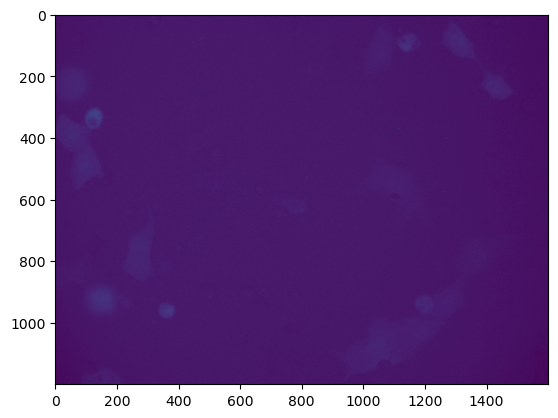

In [39]:
plt.imshow(gfp[1199])
plt.show()

In [16]:
### launch napari
#with napari.gui_qt():
viewer = napari.Viewer()
    
### add imagesirfp_tracks[0]
#viewer.add_image(bf, name = "brightfield")
viewer.add_image(gfp, name="gfp", blending = "additive", colormap = "green")
viewer.add_image(rfp, name="rfp", contrast_limits = (0, 50), blending = "additive", colormap = "magenta")
viewer.add_image(irfp, name="irfp", blending = "additive", colormap = "cyan")
#viewer.add_image(masks, name="masks", blending = "additive", colormap = "magenta")

## add tracks
#viewer.add_tracks(tracks)
#viewer.add_tracks(irfp_tracks)
#viewer.add_tracks(scr_tracks)
napari.run()

# printing tracks

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

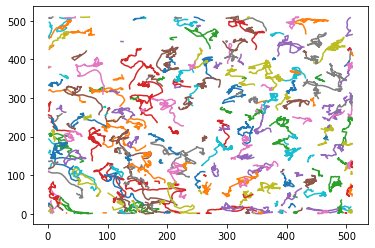

In [14]:
for i in range(len(tracks)):
    plt.plot(tracks[i].x, tracks[i].y)

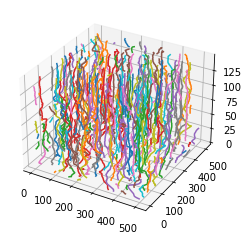

<Figure size 720x720 with 0 Axes>

In [30]:
ax = plt.axes(projection='3d')
plt.figure(figsize=(10,10))
for i in range(len(tracks)):
    ax.plot3D(tracks[i].x, tracks[i].y, tracks[i].t)